In [7]:
!pip install langgraph langchain langchain_openai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.3 MB/s eta 0:00:00


In [8]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [9]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [10]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [11]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: 'action', False: END},
        )
        graph.add_edge("action","llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
    
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
    
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)]+messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}     

In [12]:
import os

prompt = """
你是一位聪明的研究助理。使用搜索引擎查找信息。你可以进行多次调用（可以一起或按顺序）。只有在你确定自己需要什么信息时才查找信息。如果你需要在提出后续问题之前查找一些信息，你可以这样做！
"""
api_key = os.environ.get("MY_API_KEY")
base_url = os.environ.get("OPENAI_API_BASE")
model = ChatOpenAI(api_key=api_key, base_url=base_url,model="gpt-4-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

In [13]:
!python --version

Python 3.10.14


In [14]:
!pip install pygraphviz

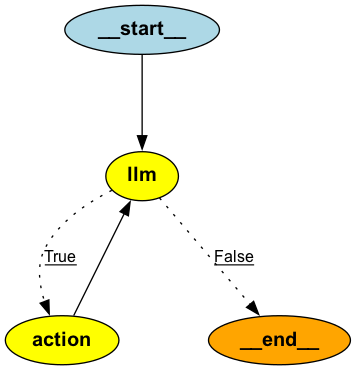

In [15]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [16]:
messages = [HumanMessage(content="西安今天的天气如何?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '西安今天的天气'}, 'id': 'call_x6M2rAvE8mJ3zgEBRLJZWdJD', 'type': 'tool_call'}
Back to the model!


In [17]:
result

{'messages': [HumanMessage(content='西安今天的天气如何?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x6M2rAvE8mJ3zgEBRLJZWdJD', 'function': {'arguments': '{"query":"西安今天的天气"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 183, 'total_tokens': 208}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_0993c4a4c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11c43448-2986-4b8c-ad30-a037b3c68c2f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '西安今天的天气'}, 'id': 'call_x6M2rAvE8mJ3zgEBRLJZWdJD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 183, 'output_tokens': 25, 'total_tokens': 208}),
  ToolMessage(content="[{'url': 'https://weather.com/zh-CN/weather/today/l/469847d38b26dbfd9519a7467fbcc689c42cceb1bd104a74d6637ce8359a0fba', 'content': '今天白天和夜间的西安市, 陕西省天气预报、天气情况和多普勒雷达 - 尽在 The Weather Channel 和 Weather.com'}, {'url':

In [18]:
result['messages'][-1].content

'西安今天的天气预报可以通过以下几个链接查阅：\n1. [The Weather Channel](https://weather.com/zh-CN/weather/today/l/469847d38b26dbfd9519a7467fbcc689c42cceb1bd104a74d6637ce8359a0fba) 提供了详细的天气情况和多普勒雷达情报。\n2. [中国天气网](https://wx.weather.com.cn/mweather/101110101.shtml) 和 [另一个页面](http://www.weather.com.cn/weathern/101110101.shtml) 提供了西安的今日天气预报、一周天气预报、15日和40日天气预报，并且还包括了生活指数、健康指数等信息。\n3. [e.weather.com.cn](https://e.weather.com.cn/mweather1d/101110101.shtml) 同样提供了全面的天气预报和相关指数信息。\n\n您可以访问这些链接以获取最准确的天气信息。'

In [19]:
messages = [HumanMessage(content="西安和宝鸡今天的天气如何?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '西安今天的天气'}, 'id': 'call_VWWcKpx0eHj8xvVq8pHg04Bb', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': '宝鸡今天的天气'}, 'id': 'call_3Z2oOx9zpgWukXIbRFcKqc23', 'type': 'tool_call'}
Back to the model!


In [20]:
result['messages'][-1].content

'今天西安和宝鸡的天气如下：\n\n### 西安天气：\n- 西安今天的天气预报和情况信息可以通过多个渠道查看，包括The Weather Channel和中国中央气象台。详细的天气信息包括温度、湿度、降水概率等。\n\n### 宝鸡天气：\n- 宝鸡今天的天气预报同样可以通过多个网站查询，包括天气网和中国中央气象台。这些网站提供了包括实时天气情况、24小时天气预报、未来一周的天气趋势等。\n\n具体的温度、风力、降水等数据可以通过点击以上链接获取更详细的信息。'

In [22]:
query = "2024 年超级碗谁赢了？获胜球队的总部位于哪个州？\
那个州的国内生产总值（GDP）是多少？回答每个问题。" 
messages = [HumanMessage(content=query)]
api_key = os.environ.get("MY_API_KEY")
base_url = os.environ.get("OPENAI_API_BASE")
model = ChatOpenAI(api_key=api_key, base_url=base_url, model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_5Fh4m2RzKW9yUz1B23xZfPPF', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_4SzselOdgNSM375T6zug3jJr', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2023'}, 'id': 'call_9lFvg2hqpGfPgijA3AGBk0vI', 'type': 'tool_call'}
Back to the model!


In [23]:
print(result['messages'][-1].content)

1. **2024 年超级碗的获胜者**：堪萨斯城酋长队（Kansas City Chiefs）赢得了2024年的超级碗比赛。

2. **获胜球队的总部位于哪个州**：堪萨斯城酋长队的总部位于密苏里州（Missouri），具体地址是位于堪萨斯城的Arrowhead Stadium。

3. **那个州的国内生产总值（GDP）是多少**：截至2023年，密苏里州的GDP为4223.06亿美元。
